In [1]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import cv2
from skimage import io, transform

## Data augmentation

### Images files
The 3D cube has been split in as many 2D tiff files as there are slices, each named 'slice_numberofslice.tif'

In [ ]:
cube = io.imread('C:/Users/Thibault/Desktop/Projet Recherche 3A/Data/Data.tif')

for i in range(cube.shape[0]):
    img = cube[i,:,:]
    filename = 'slice_'+str(i)+'.tif'
    io.imsave('C:/Users/Thibault/Desktop/Projet Recherche 3A/Data/Split/'+filename,img,plugin='tifffile')

### Dataset class

We use the dataset class from pytorch to represent the data.

The data are loaded in memory slice by slice in the _getitem_ method

A dataset object is created with two arguments idx_start and idx_end which let us use only slices between those two index.
This is because the first and last slices show some artifacts.

In [2]:
class Datas(Dataset):
    def __init__(self,root='C:/Users/Thibault/Desktop/Projet Recherche 3A/Data/Split/'\
                 ,transform=None,idx_start=0,idx_end=None):
        self.root=root
        self.transformation = transform
        self.idx_start=idx_start
        if idx_end==None:
            files = os.listdir(root)
            idx_end=len(files)
        self.idx_end=idx_end
        
    
    def __len__(self):
        return self.idx_end-self.idx_start
    
    def __getitem__(self, idx):
        idx2 = self.idx_start+idx
        filename='slice_'+str(idx2)+'.tif'
        image = io.imread(self.root+filename)  
        shape = image.shape
        image = image.reshape(shape[0],shape[1],1)
        if self.transformation!=None:
            image = self.transformation(image)
        return image

### Transformations
Here we define the set of transforms applied to a slice before it is loaded.
It is first binarized with an adapted threshold, then cropped to get only the center part,
then closed with morphological operation. After this we use data augmentation transforms such as random crop,
random vertical and horizontal flips.

In [3]:
class Crop(object):
    
    def __init__(self,corner,h,w):
        # corner est un tuple (x,y) qui représente le coin en bas à gauche, w et h (width et height sont des tuples)
        self.corner=corner
        self.w=w
        self.h=h
        
    def __call__(self,sample):
        x_corner=self.corner[0]
        y_corner=self.corner[1]
        return sample[self.corner[1]:self.corner[1]+self.h,self.corner[0]:self.corner[0]+self.w,:]

class Binarize(object):
    
    def __init__(self,threshold):
        self.threshold=threshold
    
    def __call__(self,sample):
        return (sample>self.threshold).astype(int)

class Closing(object):
    
    def __init__(self,kernel_size=(3,3)):
        self.kernel = np.ones(kernel_size,np.uint8)
    
    def __call__(self,sample):
        shape = sample.shape
        closed2D = cv2.morphologyEx(np.uint8(sample.reshape(shape[0],shape[1])),cv2.MORPH_CLOSE,self.kernel)
        return closed2D.reshape(shape)

We define the transformation pipeline with transformations from torchvision.transfroms and from the above transformations

In [4]:
# These values have been determined after trials on the dataset
thresh = 45153.32
(x,y) = (73,395)
w=860
h=225
crop_size=(150,250)

transform_pipeline = transforms.Compose([Binarize(thresh),Crop((x,y),h,w),Closing(),transforms.ToPILImage(),\
                                 transforms.RandomCrop(crop_size),transforms.RandomVerticalFlip(),\
                                 transforms.RandomHorizontalFlip(),transforms.ToTensor(),\
                                 transforms.Normalize((0.00324,),(0.00142,))])

### Examples

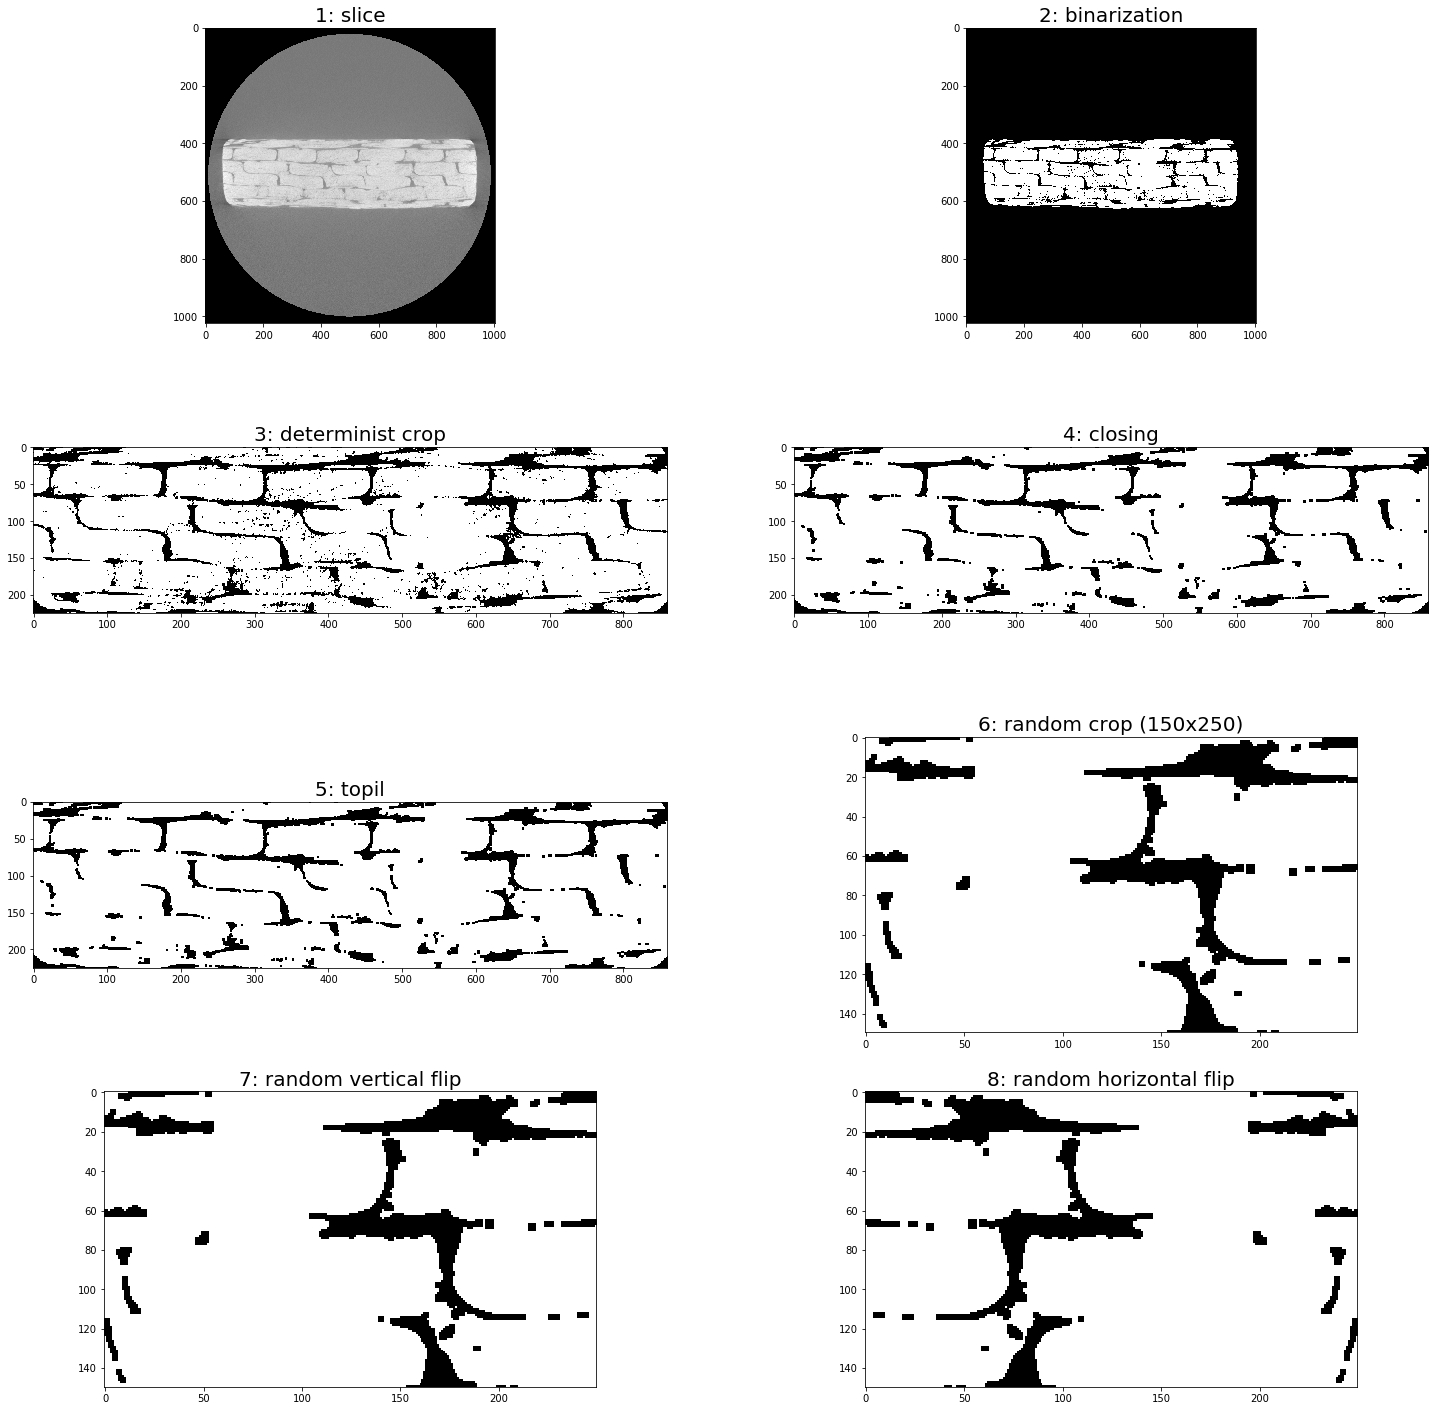

In [10]:
data = Datas()

img = data[200]

binar = Binarize(thresh)
crop = Crop((x,y),h,w)
close = Closing()
topil = transforms.ToPILImage()
rcrop = transforms.RandomCrop(crop_size)
rvflip = transforms.RandomVerticalFlip()
rhflip = transforms.RandomHorizontalFlip()

img2 = binar(img)
img3 = crop(img2)
img4 = close(img3)
img5 = topil(img4)
img6 = rcrop(img5)
img7 = rvflip(img6)
img8 = rhflip(img7)

def plot_numpy(ax,img,title):
    ax.imshow(img.reshape(img.shape[0],img.shape[1]),cmap='gray')
    ax.set_title(title,size=20)

def plot_pil(ax,img,title):
    ax.imshow(np.array(img),cmap='gray')
    ax.set_title(title,size=20)

f, axes = plt.subplots(4,2,figsize=(25,25))
plot_numpy(axes[0,0],img,'1: slice')
plot_numpy(axes[0,1],img2,'2: binarization')
plot_numpy(axes[1,0],img3,'3: determinist crop')
plot_numpy(axes[1,1],img4,'4: closing')
plot_pil(axes[2,0],img5,'5: topil')
plot_pil(axes[2,1],img6,'6: random crop (150x250)')
plot_pil(axes[3,0],img7,'7: random vertical flip')
plot_pil(axes[3,1],img8,'8: random horizontal flip')

## Net
### Percentile function
In the middle of the net, we need to get a sparse map regarding a predefined sparsity rate.
For this, we threshold the hidden map $D$ we want to make sparse with a sigmoid function: $D'=sigmoid(r(D-t))$
where t is the quantile over the whole batch of the map D, at the predefined sparsity rate level.

To get this quantile in a differentiable manner, we use the Robbins-Monro algorithm which is recursive. If $\theta_n$ is the estimator of the $\alpha$ level quantile, and $X_n$ are the variables over which we want to get the quantile (the intensity of every pixel of a 2D image in our case), then do

$\theta_{n+1}=\theta_n-\frac{2}{n+1}*(1_{(X_{n+1}\le\theta_n)}-\alpha)$

The indicator function is replaced here by a sigmoid and the quantiles are averaged over the batch dimension


In [5]:
def percentile(tens,alpha):
    n = tens.size(2)*tens.size(3)
    res = 2*(tens.view(-1,n)[:,0]<=1).to(torch.float32)-alpha
    perm=torch.randperm(n)
    for k in range(1,n):
        gamma_k=2/(k+1)
        res=res-gamma_k*(torch.sigmoid(5*(res-tens.view(-1,n)[:,perm[k]]))-alpha)
    return torch.mean(res)

In [6]:
tens = torch.randn(10,1,150,250)
n=10*150*250
t1 = percentile(tens,0.75)
t2 = percentile(tens,0.98)
rate_1 = (tens<=t1).to(torch.float32).sum()/n
rate_2 = (tens<=t2).to(torch.float32).sum()/n
print('number of pixels <t1: {}'.format(rate_1))
print('number of pixels <t2: {}'.format(rate_2))

number of pixels <t1: 0.7639600038528442
number of pixels <t2: 0.974669337272644


### net

The architecture is the one from the paper https://arxiv.org/pdf/1704.00406.pdf

In the description below, the parts 4 and 8 are omitted because the background in our images is uniform
![](capture.png)

In [6]:
class Sparse_AutoEncoder(nn.Module):
    
    def __init__(self,sparse_rate,r):
        super(Sparse_AutoEncoder, self).__init__()
        self.sparse_rate=sparse_rate
        self.r=r
        self.quantile = 1
                                                                      #1*150*250
        # --- Part 1 ---
        self.conv11=nn.Conv2d(1,40,(5,7),padding=(2,3))               #60*150*250
        self.batchNorm11 = nn.BatchNorm2d(40)
        self.conv12=nn.Conv2d(40,50,(5,7),padding=(2,3))              #80*150*250
        self.batchNorm12 = nn.BatchNorm2d(50)
        self.pool11=nn.AvgPool2d(kernel_size=2)                       #80*75*125
        self.conv13=nn.Conv2d(50,70,(5,5),padding=(2,3))             #100*75*125
        self.batchNorm13 = nn.BatchNorm2d(70)
        self.conv14=nn.Conv2d(70,90,(5,7),padding=(2,3))            #120*75*125
        self.batchNorm14 = nn.BatchNorm2d(90)
        self.pool12=nn.AvgPool2d(kernel_size=2,padding=(1,0))         #120*38*63
        self.conv15=nn.Conv2d(90,100,(3,5),padding=(1,2))            #140*38*63
        self.batchNorm15 = nn.BatchNorm2d(100)
        self.conv16=nn.Conv2d(100,110,(3,5),padding=(1,2))            #160*38*63
        self.batchNorm16 = nn.BatchNorm2d(110)

        # --- Part 2 --- fibers' centers detection
        self.conv21=nn.Conv2d(110,80,1)                               #80*38*63
        self.conv22=nn.Conv2d(80,1,1)                                 #1*38*63
        self.batchNorm22 = nn.BatchNorm2d(1,affine=False)             #1*38*63
        
        # --- Part 3 --- fibers' features
        self.conv31=nn.Conv2d(110,110,(3,5),padding=(1,2))            #130*38*63
        self.batchNorm31 = nn.BatchNorm2d(110)
        self.conv32=nn.Conv2d(110,100,(3,5),padding=(1,2))            #100*38*63
        self.batchNorm32 = nn.BatchNorm2d(100)
        
        # --- Part 4 --- deconvolution
        self.deconv41=nn.ConvTranspose2d(100,110,(3,5),padding=(1,2))     #120*38*63
        self.batchNorm41 = nn.BatchNorm2d(110)
        self.deconv42=nn.ConvTranspose2d(110,110,(3,5),padding=(1,2))     #140*38*63
        self.batchNorm42 = nn.BatchNorm2d(110)
        self.deconv43=nn.ConvTranspose2d(110,100,(3,5),padding=(1,2),stride=2)#140*75*125
        self.batchNorm43 = nn.BatchNorm2d(100)
        self.deconv44=nn.ConvTranspose2d(100,90,(3,5),padding=(1,2)) #120*75*125
        self.batchNorm44 = nn.BatchNorm2d(90)
        self.deconv45=nn.ConvTranspose2d(90,80,(3,5),padding=(1,2)) #100*75*125
        self.batchNorm45 = nn.BatchNorm2d(80)
        self.deconv46=nn.ConvTranspose2d(80,60,(3,5),padding=(1,2),stride=2,output_padding=1) #100*150*250
        self.batchNorm46 = nn.BatchNorm2d(60)
        self.deconv47=nn.ConvTranspose2d(60,40,(3,5),padding=(1,2))  #80*150*250
        self.batchNorm47 = nn.BatchNorm2d(40)
        self.deconv48=nn.ConvTranspose2d(40,40,(3,5),padding=(1,2))   #60*150*250
        
        # --- Output ---
        self.output=nn.ConvTranspose2d(40,1,1)                        #1*150*250
        
        def init_weights(m):
            if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)
        
        self.apply(init_weights)        
       
    def forward(self,x,t=None):
            
        # --- Part 1 ---
        x = F.relu(self.conv11(x))
        x = self.batchNorm11(x)
        x = F.relu(self.conv12(x))
        x = self.batchNorm12(x)
        x = self.pool11(x)
        x = F.relu(self.conv13(x))
        x = self.batchNorm13(x)
        x = F.relu(self.conv14(x))
        x = self.batchNorm14(x)
        x = self.pool12(x)
        x = F.relu(self.conv15(x))
        x = self.batchNorm15(x)
        x = F.relu(self.conv16(x))
        x = self.batchNorm16(x)
            
        # --- Part 2 ---
        x2 = F.relu(self.conv21(x))
        x2 = F.relu(self.conv22(x2))
        x2 = self.batchNorm22(x2)
        if type(t)==torch.Tensor:
            x2 = torch.sigmoid(self.r*(x2-t))
        else:
            t = percentile(x2,1-self.sparse_rate)
            x2 = torch.sigmoid(self.r*(x2-t))
        
        # --- Part 3 ---
        x = F.relu(self.conv31(x))
        x = self.batchNorm31(x)
        x = F.relu(self.conv32(x))
        x = self.batchNorm32(x)
            
        # --- Dotwise Product ---
        x = x2.expand(-1,100,-1,-1)*x
            
        # --- Part 4 ---
        x = F.relu(self.deconv41(x))
        x = self.batchNorm41(x)
        x = F.relu(self.deconv42(x))
        x = self.batchNorm42(x)
        x = F.relu(self.deconv43(x))
        x = self.batchNorm43(x)
        x = F.relu(self.deconv44(x))
        x = self.batchNorm44(x)
        x = F.relu(self.deconv45(x))
        x = self.batchNorm45(x)
        x = F.relu(self.deconv46(x))
        x = self.batchNorm46(x)
        x = F.relu(self.deconv47(x))
        x = self.batchNorm47(x)
        x = F.relu(self.deconv48(x))
            
        x = torch.sigmoid(self.output(x))
            
        return {'detection':x2,'reconstruction':x, 'quantile':t}

## Training

In the training phase, we keep track of the quantiles by a moving average updated at each iteration:
$mav_{n+1}=(1-\alpha)mav_{n}+\alpha{t_n}$ where $t_n$ is the quantile calculated at iteration

In [7]:
def control_plot(datas,detection,reconstruction):
    f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,15))
    ax1.imshow(datas.detach().cpu().numpy()[0,0,:,:],cmap='gray')
    ax1.set_title('input')
    ax2.imshow(detection.detach().cpu().numpy()[0,0,:,:],cmap='gray')
    ax2.set_title('detection')
    ax3.imshow(reconstruction.detach().cpu().numpy()[0,0,:,:],cmap='gray')
    ax3.set_title('reconstruction')
    plt.show()

cuda:0
Epoch n°0

iteration 0   0/800 examples processed
	loss: 0.9401130676269531
	threshold:
		running  1.1187688112258911
		batch 2.187687873840332
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.04285109043121338
		 real : 0.0


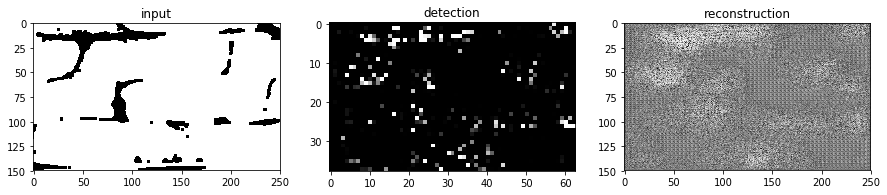

iteration 1   14/800 examples processed
	loss: 1.0454044342041016
	threshold:
		running  1.2269989252090454
		batch 2.201071262359619
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.028837351128458977
		 real : 0.0


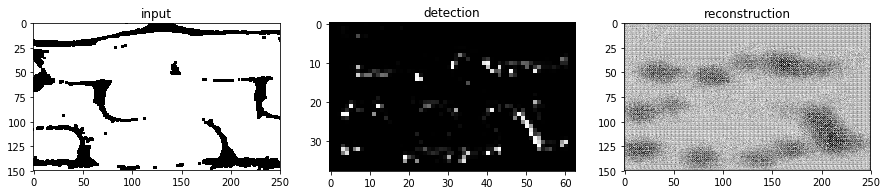

iteration 2   28/800 examples processed
	loss: 0.9365156292915344
	threshold:
		running  1.313460350036621
		batch 2.091614246368408
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.04702946916222572
		 real : 0.0


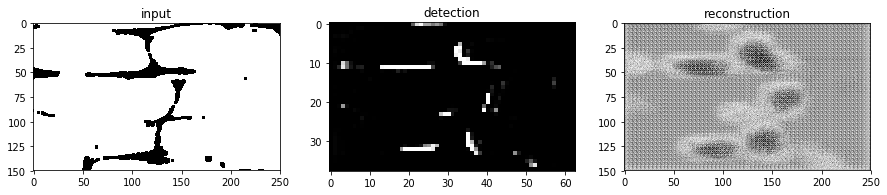

iteration 3   42/800 examples processed
	loss: 0.816737174987793
	threshold:
		running  1.3921533823013306
		batch 2.100391387939453
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.04329044744372368
		 real : 0.0


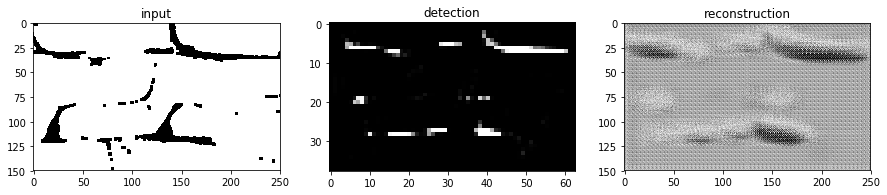

iteration 4   56/800 examples processed
	loss: 0.8773333430290222
	threshold:
		running  1.462465524673462
		batch 2.0952749252319336
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.055018551647663116
		 real : 0.0


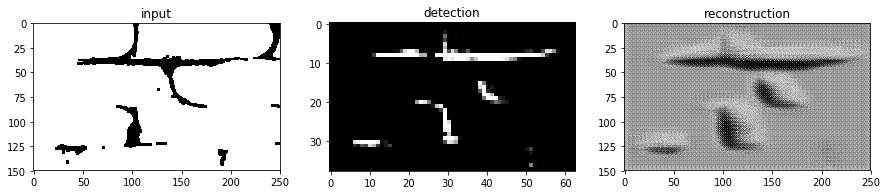

iteration 5   70/800 examples processed
	loss: 0.796980082988739
	threshold:
		running  1.5338749885559082
		batch 2.176560163497925
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.05349572002887726
		 real : 0.0


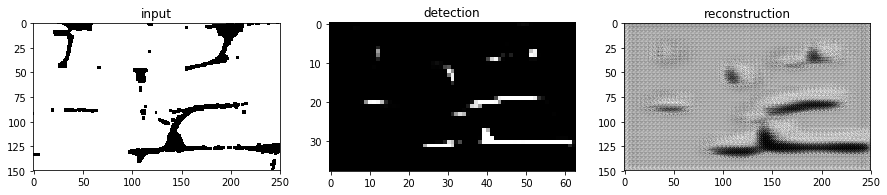

iteration 6   84/800 examples processed
	loss: 0.7493947744369507
	threshold:
		running  1.5893784761428833
		batch 2.088909864425659
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.0584789477288723
		 real : 0.0


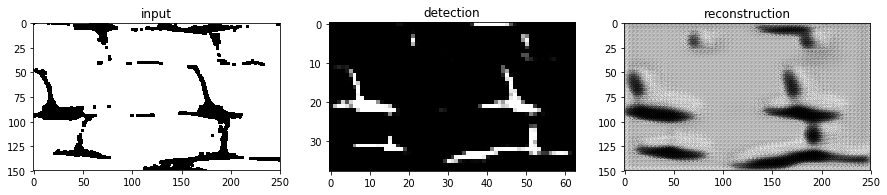

iteration 7   98/800 examples processed
	loss: 0.6513233780860901
	threshold:
		running  1.6415735483169556
		batch 2.111330032348633
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.05728956684470177
		 real : 0.0


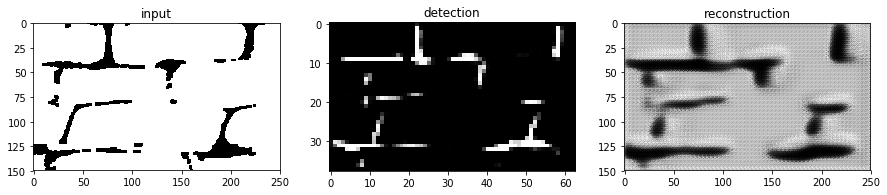

iteration 8   112/800 examples processed
	loss: 0.6250694990158081
	threshold:
		running  1.691127896308899
		batch 2.137117385864258
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.0603499598801136
		 real : 0.0


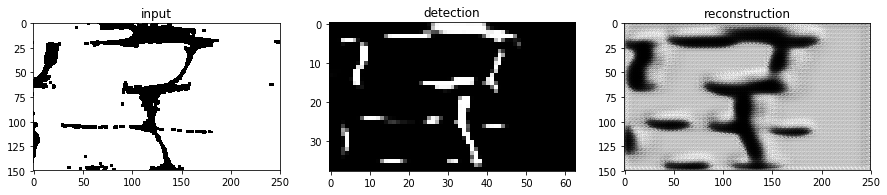

iteration 9   126/800 examples processed
	loss: 0.6626673340797424
	threshold:
		running  1.754964828491211
		batch 2.329497814178467
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.05584454536437988
		 real : 0.0


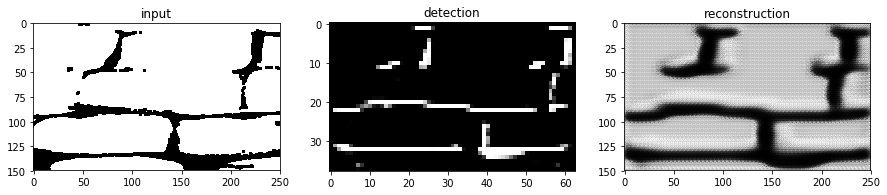

iteration 10   140/800 examples processed
	loss: 0.6605001091957092
	threshold:
		running  1.803139090538025
		batch 2.236708879470825
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.05926534906029701
		 real : 0.0


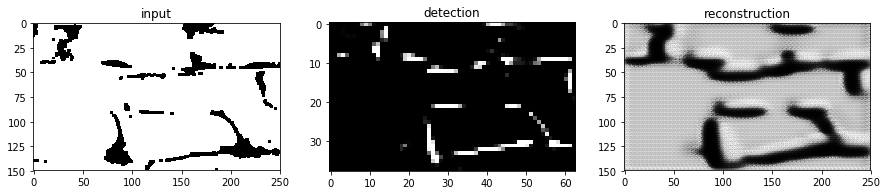

iteration 11   154/800 examples processed
	loss: 0.6190377473831177
	threshold:
		running  1.8368148803710938
		batch 2.139897346496582
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06424549221992493
		 real : 0.0


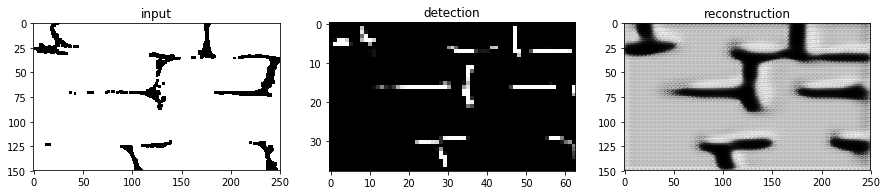

iteration 12   168/800 examples processed
	loss: 0.6353313326835632
	threshold:
		running  1.8706775903701782
		batch 2.1754424571990967
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06563033908605576
		 real : 0.0


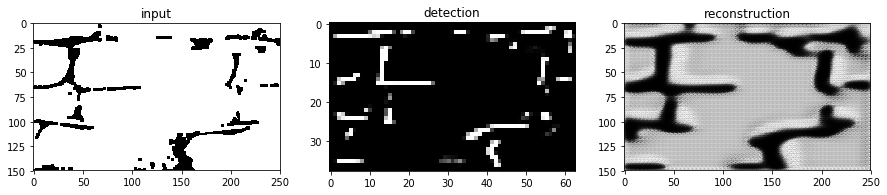

iteration 13   182/800 examples processed
	loss: 0.6378298997879028
	threshold:
		running  1.905354380607605
		batch 2.2174453735351562
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06287285685539246
		 real : 0.0


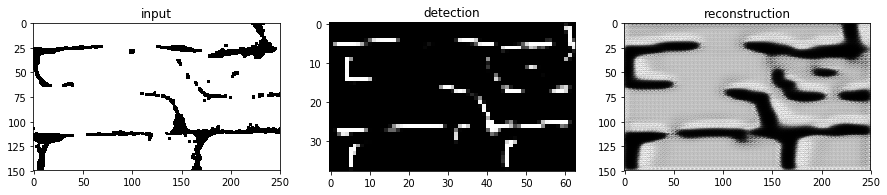

iteration 14   196/800 examples processed
	loss: 0.6382346153259277
	threshold:
		running  1.9236252307891846
		batch 2.0880632400512695
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.0687108114361763
		 real : 0.0


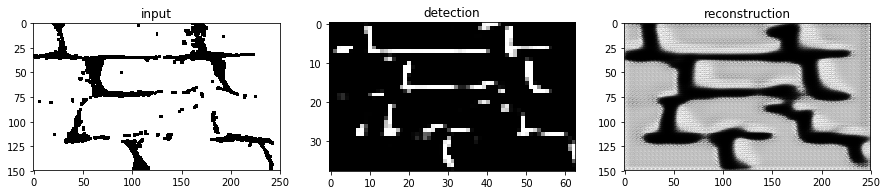

iteration 15   210/800 examples processed
	loss: 0.6000426411628723
	threshold:
		running  1.952386736869812
		batch 2.211240768432617
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06412046402692795
		 real : 0.0


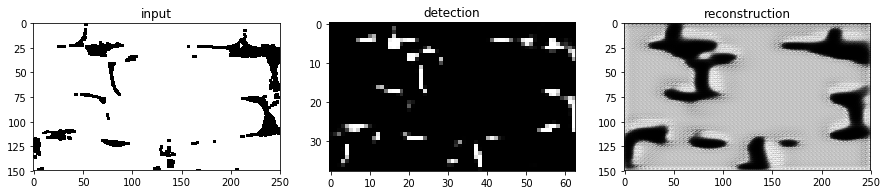

iteration 16   224/800 examples processed
	loss: 0.6648465394973755
	threshold:
		running  1.9846271276474
		batch 2.2747912406921387
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.061670709401369095
		 real : 0.0


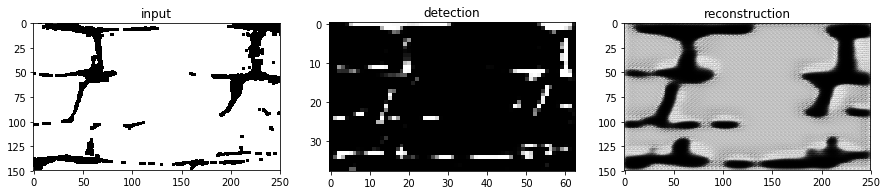

iteration 17   238/800 examples processed
	loss: 0.6073138117790222
	threshold:
		running  2.0003485679626465
		batch 2.1418416500091553
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06533552706241608
		 real : 0.0


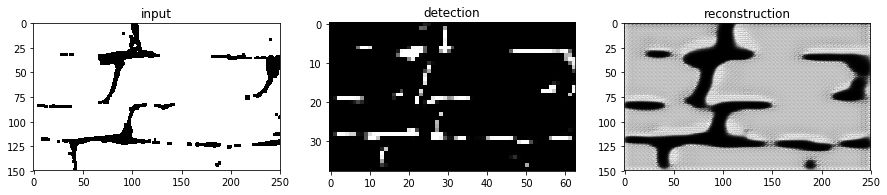

iteration 18   252/800 examples processed
	loss: 0.6003709435462952
	threshold:
		running  2.0168628692626953
		batch 2.1654915809631348
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06605558097362518
		 real : 0.0


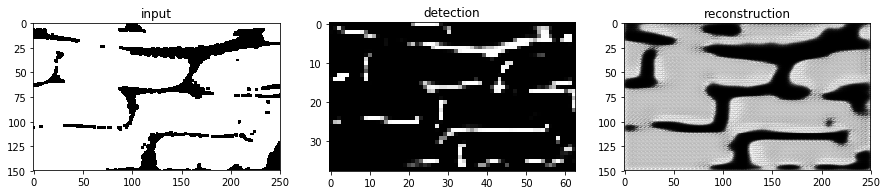

iteration 19   266/800 examples processed
	loss: 0.6158850789070129
	threshold:
		running  2.0375189781188965
		batch 2.2234253883361816
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06398933380842209
		 real : 0.0


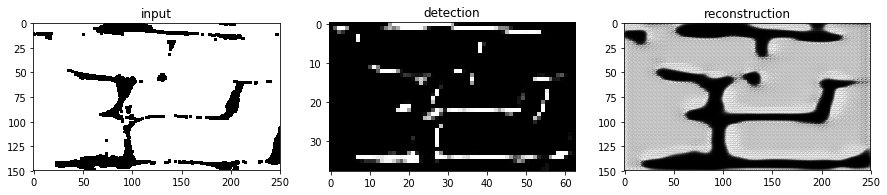

iteration 20   280/800 examples processed
	loss: 0.6187376379966736
	threshold:
		running  2.0724825859069824
		batch 2.387155294418335
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.057168927043676376
		 real : 0.0


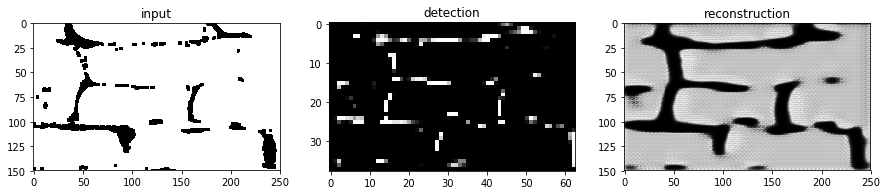

iteration 21   294/800 examples processed
	loss: 0.6149548292160034
	threshold:
		running  2.0774593353271484
		batch 2.122251033782959
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.0695401281118393
		 real : 0.0


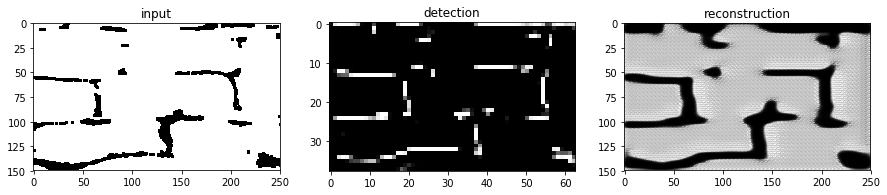

iteration 22   308/800 examples processed
	loss: 0.6022258996963501
	threshold:
		running  2.1008682250976562
		batch 2.311549425125122
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06023881956934929
		 real : 0.0


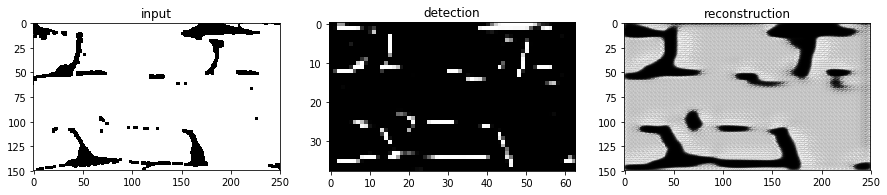

iteration 23   322/800 examples processed
	loss: 0.6406243443489075
	threshold:
		running  2.1147642135620117
		batch 2.2398276329040527
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06502261757850647
		 real : 0.0


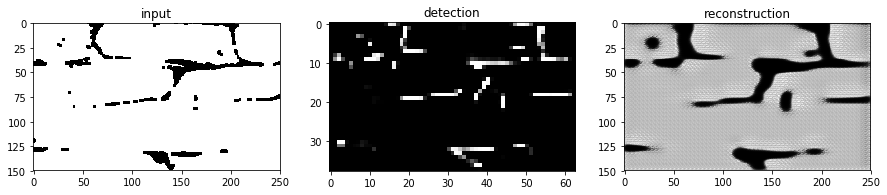

iteration 24   336/800 examples processed
	loss: 0.5666579604148865
	threshold:
		running  2.116710901260376
		batch 2.1342315673828125
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06867445260286331
		 real : 0.0


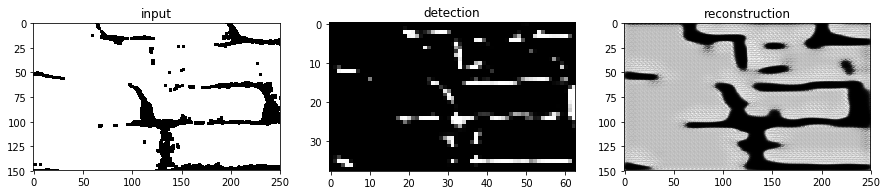

iteration 25   350/800 examples processed
	loss: 0.5775697827339172
	threshold:
		running  2.1335368156433105
		batch 2.2849693298339844
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.061587393283843994
		 real : 0.0


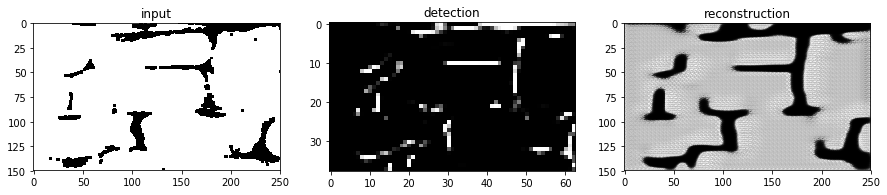

iteration 26   364/800 examples processed
	loss: 0.5595002174377441
	threshold:
		running  2.1423280239105225
		batch 2.221449375152588
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.0665440559387207
		 real : 0.0


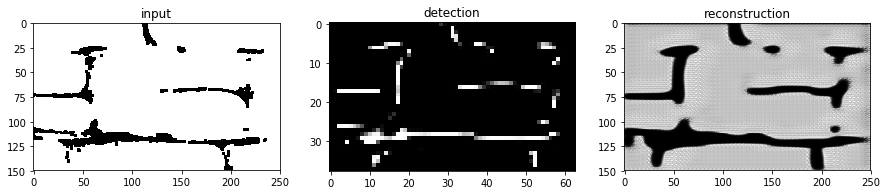

iteration 27   378/800 examples processed
	loss: 0.6315004825592041
	threshold:
		running  2.150801181793213
		batch 2.227059841156006
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06718932837247849
		 real : 0.0


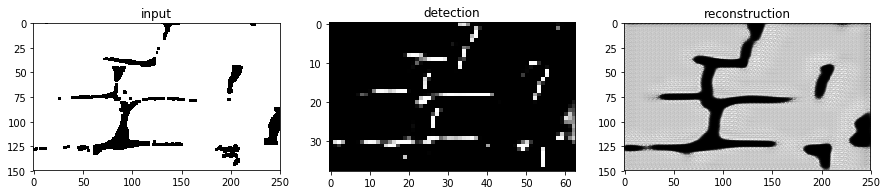

iteration 28   392/800 examples processed
	loss: 0.5961365103721619
	threshold:
		running  2.133967876434326
		batch 1.9824682474136353
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.07878813147544861
		 real : 0.0


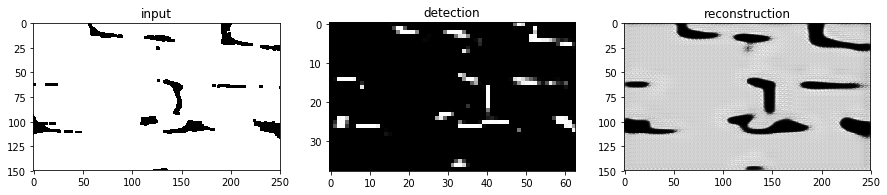

iteration 29   406/800 examples processed
	loss: 0.5463007688522339
	threshold:
		running  2.1357100009918213
		batch 2.1513898372650146
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.0718785971403122
		 real : 0.0


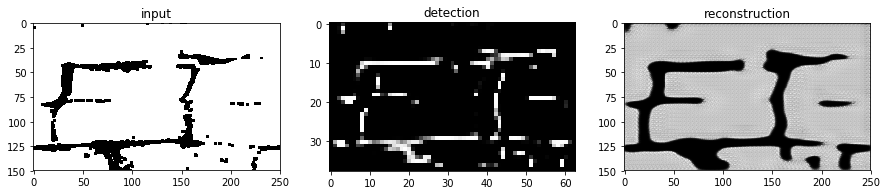

iteration 30   420/800 examples processed
	loss: 0.5865088701248169
	threshold:
		running  2.1425981521606445
		batch 2.2045931816101074
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06884434074163437
		 real : 0.0


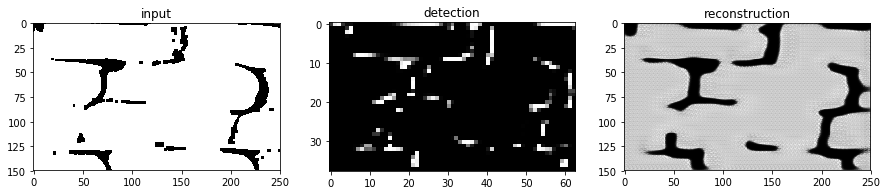

iteration 31   434/800 examples processed
	loss: 0.6016770601272583
	threshold:
		running  2.1528799533843994
		batch 2.245417594909668
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.0666554719209671
		 real : 0.0


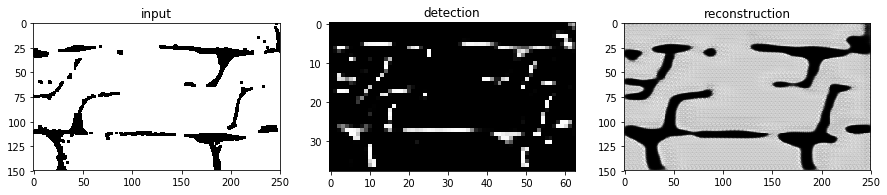

iteration 32   448/800 examples processed
	loss: 0.6376434564590454
	threshold:
		running  2.1679649353027344
		batch 2.3037312030792236
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.0624895915389061
		 real : 0.0


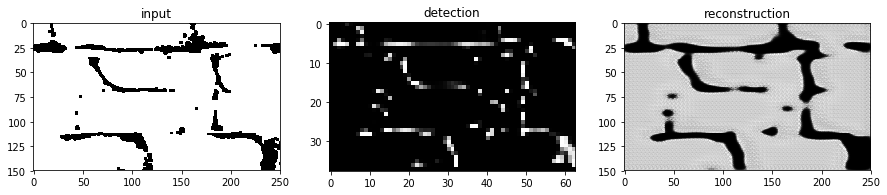

iteration 33   462/800 examples processed
	loss: 0.6051257252693176
	threshold:
		running  2.1708457469940186
		batch 2.1967742443084717
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06998199224472046
		 real : 0.0


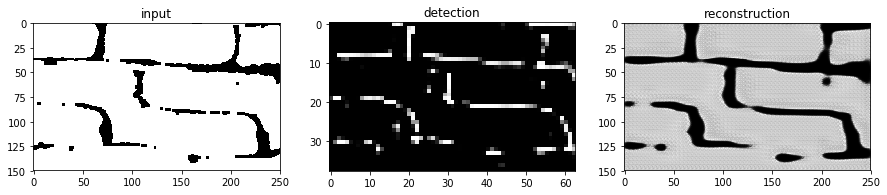

iteration 34   476/800 examples processed
	loss: 0.6207926869392395
	threshold:
		running  2.1847872734069824
		batch 2.310262441635132
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06415367126464844
		 real : 0.0


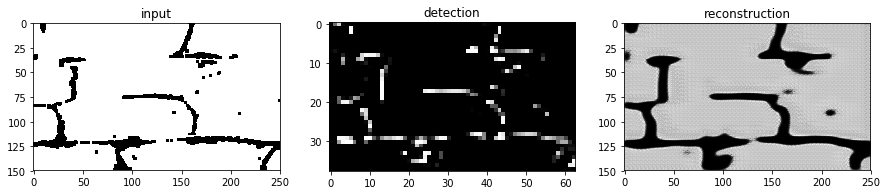

iteration 35   490/800 examples processed
	loss: 0.6024346351623535
	threshold:
		running  2.1936748027801514
		batch 2.2736637592315674
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06450114399194717
		 real : 0.0


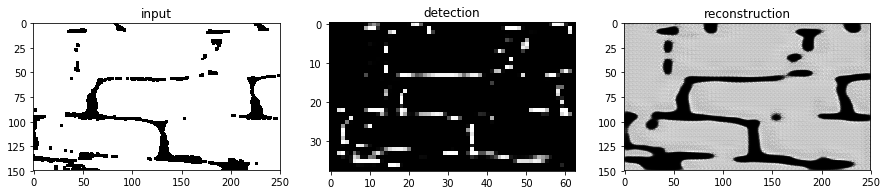

iteration 36   504/800 examples processed
	loss: 0.6352798342704773
	threshold:
		running  2.2082977294921875
		batch 2.33990478515625
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06087105721235275
		 real : 0.0


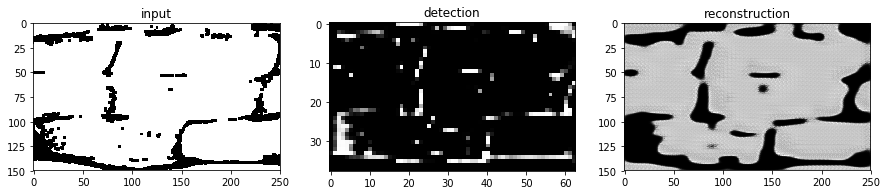

iteration 37   518/800 examples processed
	loss: 0.6516819596290588
	threshold:
		running  2.2100589275360107
		batch 2.2259109020233154
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06952805817127228
		 real : 0.0


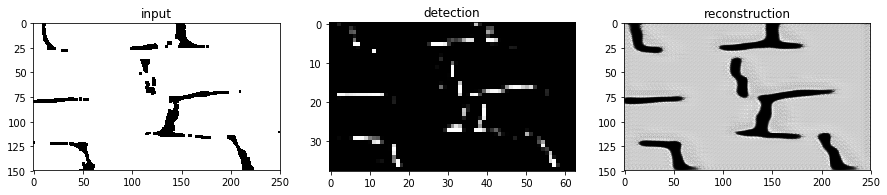

iteration 38   532/800 examples processed
	loss: 0.6180132031440735
	threshold:
		running  2.20914363861084
		batch 2.2009074687957764
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.07151111215353012
		 real : 0.0


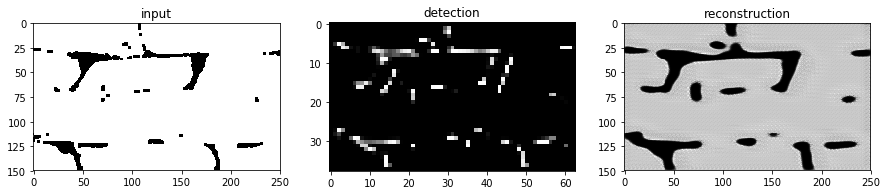

iteration 39   546/800 examples processed
	loss: 0.5767419338226318
	threshold:
		running  2.2225658893585205
		batch 2.3433661460876465
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06451409310102463
		 real : 0.0


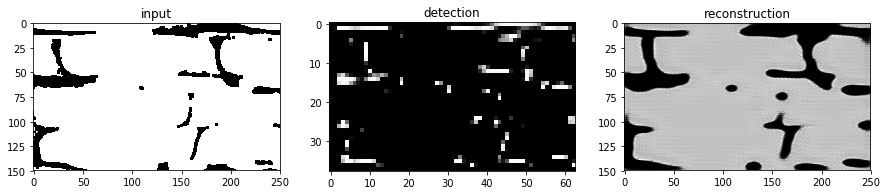

iteration 40   560/800 examples processed
	loss: 0.59942626953125
	threshold:
		running  2.220364809036255
		batch 2.2005550861358643
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.07186117023229599
		 real : 0.0


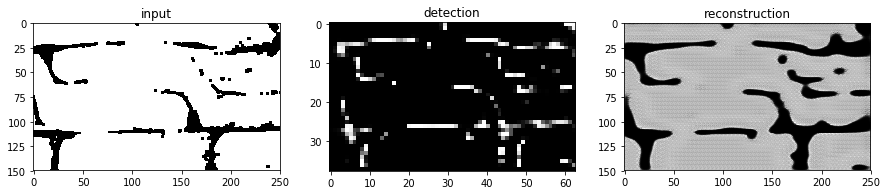

iteration 41   574/800 examples processed
	loss: 0.5618767738342285
	threshold:
		running  2.2308573722839355
		batch 2.325289249420166
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06453246623277664
		 real : 0.0


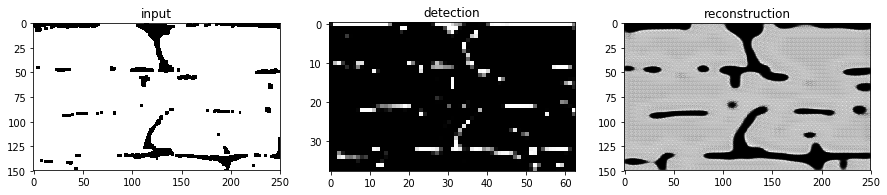

iteration 42   588/800 examples processed
	loss: 0.6221160292625427
	threshold:
		running  2.2232837677001953
		batch 2.155122756958008
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.07284442335367203
		 real : 0.0


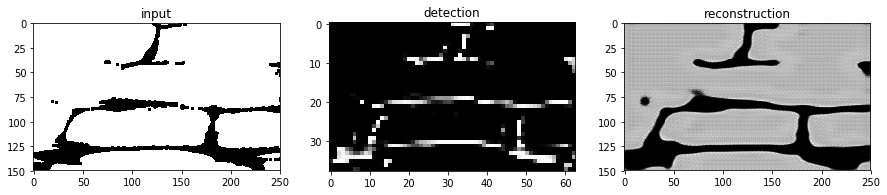

iteration 43   602/800 examples processed
	loss: 0.62807697057724
	threshold:
		running  2.23850154876709
		batch 2.3754632472991943
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.058985497802495956
		 real : 0.0


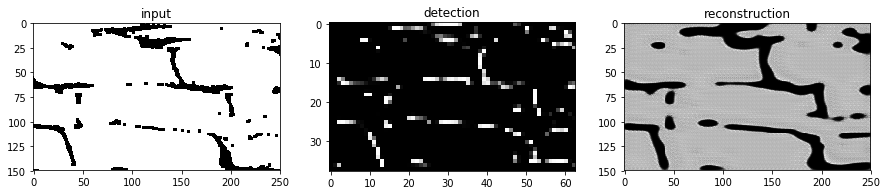

iteration 44   616/800 examples processed
	loss: 0.6284653544425964
	threshold:
		running  2.2448015213012695
		batch 2.3015029430389404
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06380170583724976
		 real : 0.0


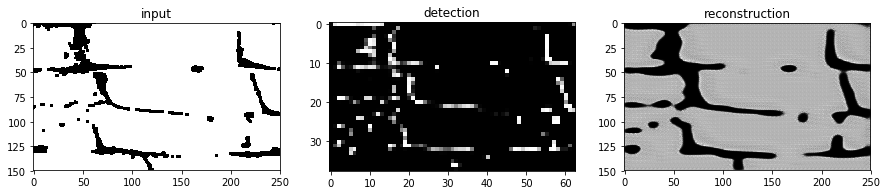

iteration 45   630/800 examples processed
	loss: 0.6457162499427795
	threshold:
		running  2.2599759101867676
		batch 2.3965444564819336
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.058304253965616226
		 real : 0.0


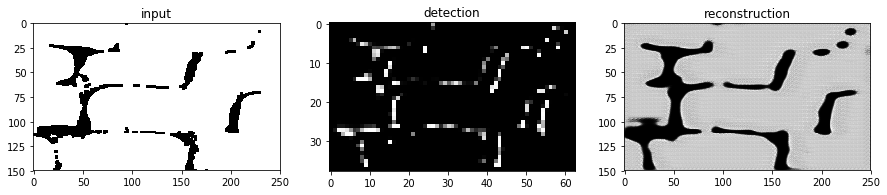

iteration 46   644/800 examples processed
	loss: 0.5856369137763977
	threshold:
		running  2.262629270553589
		batch 2.286510944366455
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06801453232765198
		 real : 0.0


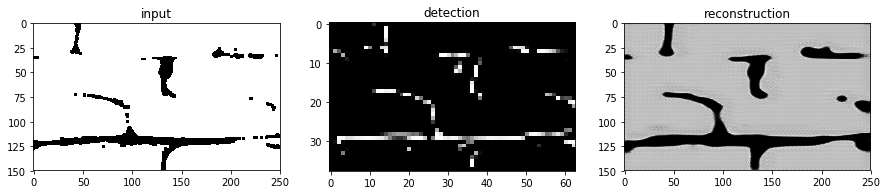

iteration 47   658/800 examples processed
	loss: 0.542445719242096
	threshold:
		running  2.2710206508636475
		batch 2.346543788909912
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06498760730028152
		 real : 0.0


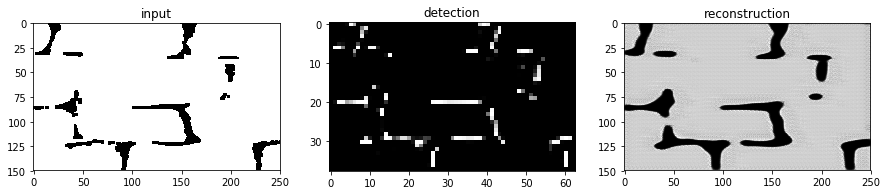

iteration 48   672/800 examples processed
	loss: 0.5747283697128296
	threshold:
		running  2.2695789337158203
		batch 2.2566041946411133
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.07003913074731827
		 real : 0.0


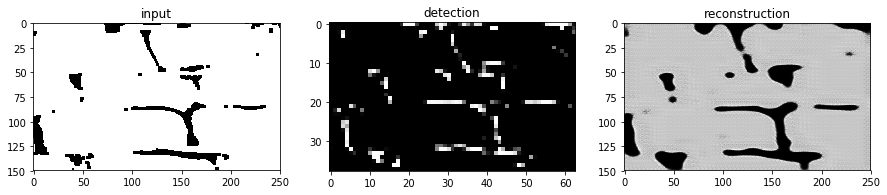

iteration 49   686/800 examples processed
	loss: 0.5880788564682007
	threshold:
		running  2.2630434036254883
		batch 2.204226016998291
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.07192321121692657
		 real : 0.0


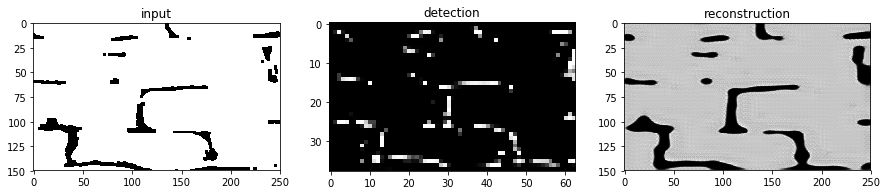

iteration 50   700/800 examples processed
	loss: 0.6062988638877869
	threshold:
		running  2.263598680496216
		batch 2.268596649169922
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06821559369564056
		 real : 0.0


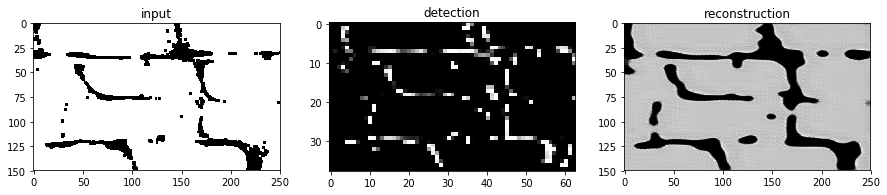

iteration 51   714/800 examples processed
	loss: 0.6030752062797546
	threshold:
		running  2.2716221809387207
		batch 2.3438339233398438
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06350913643836975
		 real : 0.0


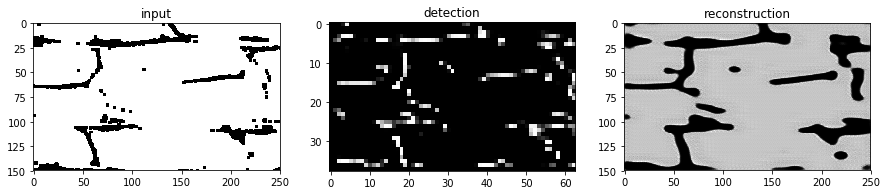

iteration 52   728/800 examples processed
	loss: 0.5969359278678894
	threshold:
		running  2.2908663749694824
		batch 2.46406626701355
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.05538666993379593
		 real : 0.0


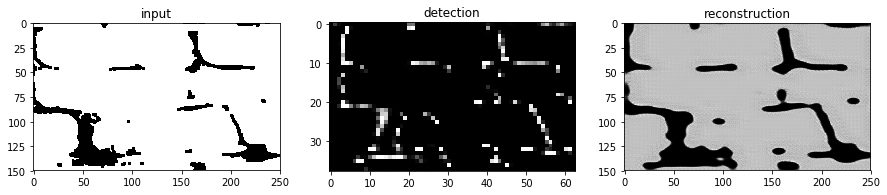

iteration 53   742/800 examples processed
	loss: 0.5885776281356812
	threshold:
		running  2.296328544616699
		batch 2.3454885482788086
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.064754419028759
		 real : 0.0


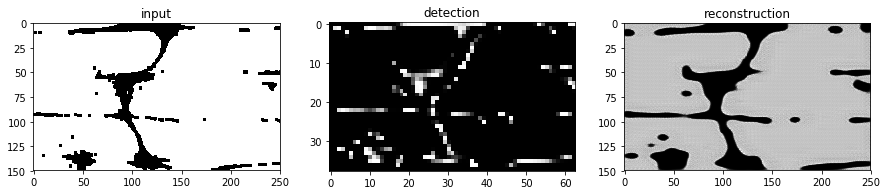

iteration 54   756/800 examples processed
	loss: 0.5564849376678467
	threshold:
		running  2.308166742324829
		batch 2.4147109985351562
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.061997294425964355
		 real : 0.0


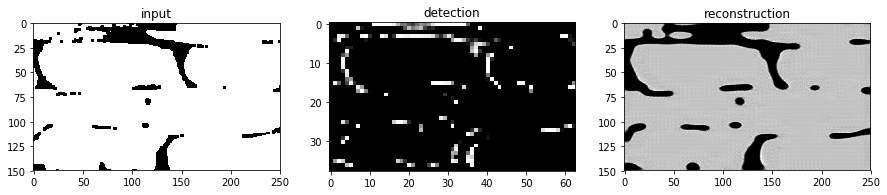

iteration 55   770/800 examples processed
	loss: 0.5717558860778809
	threshold:
		running  2.3105225563049316
		batch 2.331725597381592
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06708668172359467
		 real : 0.0


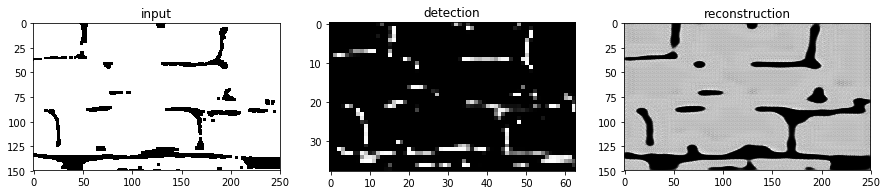

iteration 56   784/800 examples processed
	loss: 0.6289703249931335
	threshold:
		running  2.302685499191284
		batch 2.2321529388427734
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.07244940102100372
		 real : 0.0


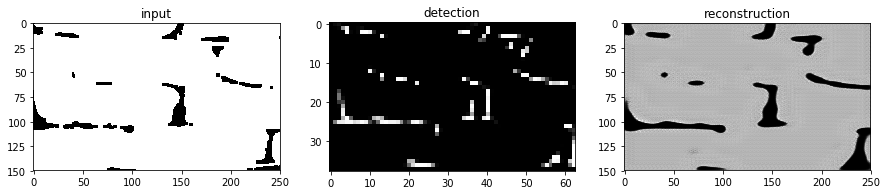

iteration 57   798/800 examples processed
	loss: 0.6414713263511658
	threshold:
		running  2.3123013973236084
		batch 2.398845911026001
	sparsity rate 
		 assuming sigmoid thresholds perfectly : 0.06079154089093208
		 real : 0.0


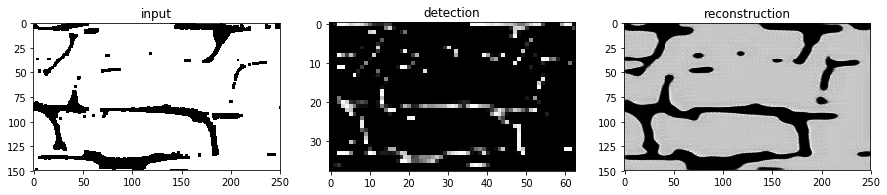

In [39]:
batch_size=14
num_epochs=1
sparsity = 0.002   #The desired sparsity rate
alpha=0.1
r=5    #quantifies the fuzziness of the detection map (high => binary map, low => range of values between 0 and 1)

def control_plot(datas,detection,reconstruction):
    f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,15))
    ax1.imshow(datas.detach().cpu().numpy()[0,0,:,:],cmap='gray')
    ax1.set_title('input')
    ax2.imshow(detection.detach().cpu().numpy()[0,0,:,:],cmap='gray')
    ax2.set_title('detection')
    ax3.imshow(reconstruction.detach().cpu().numpy()[0,0,:,:],cmap='gray')
    ax3.set_title('reconstruction')
    plt.show()
    
dataset = Datas(transform=transform_pipeline,idx_start=100,idx_end=900)
trainloader = DataLoader(dataset,shuffle=True,batch_size=batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Sparse_AutoEncoder(sparsity,r)
net.to(device)
net.train()

mse = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(net.parameters())
running_percentile = 1

for epoch in range(num_epochs):
    print('Epoch n°{}\n'.format(epoch))
    running_percentile = 1
    for i, data in enumerate(trainloader, 0):
        
        optimizer.zero_grad()
        
        data = data.to(device)
        outputs = net(data)
        detection = outputs['detection']
        reconstruction = outputs['reconstruction']
        
        loss = mse(reconstruction,data)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            net.quantile = (1-alpha)*net.quantile + alpha*outputs['quantile']
            
        num_examples=0
        if i*batch_size<len(dataset):
            num_examples=i*batch_size
        else:
            num_examples=len(dataset)
        
        print('iteration {}   {}/{} examples processed'.format(i,num_examples,len(dataset)))
        print('\tloss: {}'.format(loss.item()))
        print('\tthreshold:')
        print('\t\trunning  {}'.format(net.quantile))
        print('\t\tbatch {}'.format(outputs['quantile']))
        print('\tsparsity rate ')
        print('\t\t assuming sigmoid thresholds perfectly : {}'.format(detection.detach().sum()/np.array(detection.detach().size()).prod()))
        print('\t\t real : {}'.format((detection.detach()>=outputs['quantile'].detach()).to(torch.float32).sum()/np.array(detection.detach().size()).prod()))
        control_plot(data,detection,reconstruction)

## Test

### Formating the data

To use the network on an image, we do patches of the required size to be inputed to the network.
Th image is mirrored horizontaly and verticaly to deal with the patches that would lay outside the originale image

In [9]:
class DoubleFlip(object):
    def __init__(self):
        pass
    
    def __call__(self,sample):
        res = np.concatenate([np.flip(sample,axis=0),sample],axis=0)
        res = np.concatenate([res,np.flip(res,axis=1)],axis=1)
        return res

class Patch(object):
    def __init__(self,crop_size):
        self.h=crop_size[0]
        self.w=crop_size[1]
        
        
    def __call__(self,sample):
        H = sample.shape[0]//2
        W = sample.shape[1]//2
        
        n = (W//self.w)+1
        m = (H//self.h)+1
        
        res=[[] for x in range(m)]
        
        for j in range(m):
            for i in range(n):
                res[j].append(sample[j*self.h:(j+1)*self.h,i*self.w:(i+1)*self.w,:])
        return res

In [10]:
thresh = 45153.32
(x,y) = (73,395)
w=860
h=225
crop_size=(150,250)

transform_crop = transforms.Compose([Binarize(thresh),\
                                     Crop((x,y),h,w),\
                                     Closing(),\
                                     DoubleFlip(),\
                                     Patch(crop_size)])

transform2 = transforms.Compose([transforms.ToPILImage(),\
                                 transforms.ToTensor(),\
                                 transforms.Normalize((0.00324,),(0.00142,))])

**Exemple**
We can see the mirroring effect on the 4 upper patches and on the 2 rightmost patches

Text(0.5, 0.98, 'patches')

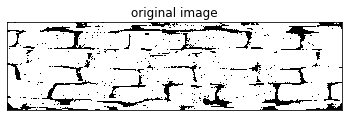

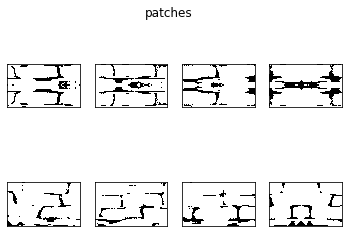

In [47]:
dataset = Datas(idx_start=100,idx_end=900)
img = dataset[200]
binar = Binarize(thresh)
crop = Crop((x,y),h,w)
img2 = crop(binar(img))
res = transform_crop(img)
f, ax = plt.subplots(1,1)
ax.imshow(img2.reshape(img2.shape[:2]),cmap='gray')
ax.set_title('original image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
n = len(res)
m = len(res[0])
f, axes = plt.subplots(n,m)
for i in range(n):
    for j in range(m):
        axes[n-1-i][j].imshow(res[i][j].reshape(res[i][j].shape[:2]),cmap='gray',origin='lower')
        axes[n-1-i][j].get_xaxis().set_visible(False)
        axes[n-1-i][j].get_yaxis().set_visible(False)
f.suptitle('patches')

In [11]:
def get_inputs(img):
    '''Returns a list containing the 8 patches preprocessed for the net '''
    res = transform_crop(img)
    n = len(res)
    m = len(res[0])
    for i in range(n):
        for j in range(m):
            res[i][j] = transform2(res[i][j])
    return res

### Passing through the net

In [32]:
w=860
h=225
def get_outputs(net,inputs):
    net.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(inputs)
    m = len(inputs[0])
    res_det=[[] for x in range(n)]
    res_rec=[[] for x in range(n)]
    for i in range(n):
        for j in range(m):
            out = net(inputs[i][j].to(device).view((1,1,150,250)),net.quantile)
            res_det[i].append(out['detection'].detach().cpu().numpy().squeeze())
            res_rec[i].append(out['reconstruction'].detach().cpu().numpy().squeeze())
    detection = np.concatenate([res_det[0][j] for j in range(m)], axis=1)
    reconstruction = np.concatenate([res_rec[0][j] for j in range(m)], axis=1)
    for k in range(1,n):
        temp_det = np.concatenate([res_det[k][j] for j in range(m)], axis=1)
        temp_rec = np.concatenate([res_rec[k][j] for j in range(m)], axis=1)
        
        detection = np.concatenate([detection,temp_det],axis=0)
        reconstruction = np.concatenate([reconstruction,temp_rec],axis=0)
    
    detection = detection[:h,:w]
    reconstruction = reconstruction[:h,:w]
    
    return {'detection':detection,'reconstruction':reconstruction}
    

### Plot

In [47]:
dataset = Datas(idx_start=100,idx_end=900)
img = dataset[100]

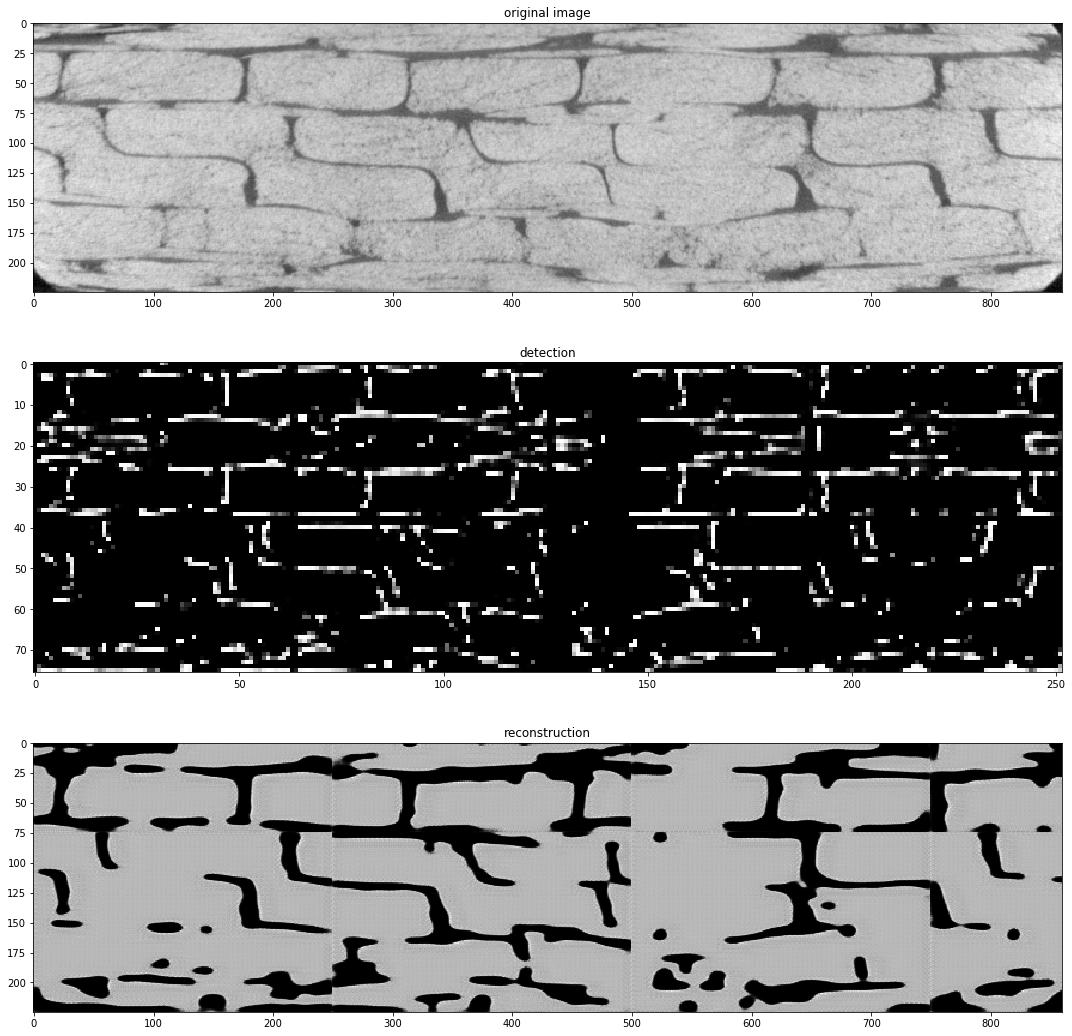

In [48]:
inputs = get_inputs(img)
crop = Crop((x,y),h,w)
img = crop(img)
outputs = get_outputs(net,inputs)
detection = np.flip(outputs['detection'],axis=0)
reconstruction = np.flip(outputs['reconstruction'],axis=0)
f, axes = plt.subplots(3,1,figsize=(15,15))
axes[0].imshow(img.squeeze(),cmap='gray')
axes[0].set_title('original image')
axes[1].imshow(detection,cmap='gray')
axes[1].set_title('detection')
axes[2].imshow(reconstruction,cmap='gray')
axes[2].set_title('reconstruction')
f.tight_layout()

In [29]:
inputs = get_inputs(img)
outputs = get_outputs(net,inputs)

In [30]:
outputs[0][0].shape

(38, 63)